In [1]:
from processor.processor import Processor as processor
from database.adatabase import ADatabase
from xgboost import XGBRegressor
from statistics import mean
import math
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tqdm import tqdm
from dotenv import load_dotenv
from asset.stock import Stock
from asset.bond import Bond
from asset.option import Option
import warnings
import pytz
import copy
warnings.simplefilter(action="ignore")
import pickle

In [2]:
market = ADatabase("market")
sec = ADatabase("sec")
market = ADatabase("market")
fred = ADatabase("fred")
db = ADatabase("sapling")

In [3]:
sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",attrs={"id":"constituents"})[0].rename(columns={"Symbol":"ticker"})

In [4]:
sp500

,ticker,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
500,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


In [5]:
fred.connect()
market_yield = fred.retrieve("market_yield")
market_yield = market_yield.rename(columns={"value":"rf"})
market_yield["rf"] = market_yield["rf"].replace(".",np.nan)
market_yield.dropna(inplace=True)
market_yield["rf"] = [float(x)/100 for x in market_yield["rf"]]
market_yield["date"] = market_yield["date"].shift(-5)
market_yield = processor.column_date_processing(market_yield)
spy = fred.retrieve("sp500")
spy = spy.rename(columns={"value":"spy"})
spy["spy"] = spy["spy"].replace(".",np.nan)
spy.dropna(inplace=True)
spy["spy"] = [float(x) for x in spy["spy"]]
spy["date"] = spy["date"].shift(-5)
spy = processor.column_date_processing(spy)
fred.disconnect()

In [6]:
prices = []
market.connect()
db.cloud_connect()
for ticker in tqdm(sp500["ticker"].unique()):
    try:
        price = processor.column_date_processing(market.query("prices",{"ticker":ticker}))
        price.sort_values("date",inplace=True)
        price = price.merge(spy[["date","spy"]],on="date",how="left")
        price = price.merge(market_yield[["date","rf"]],on="date",how="left")
        price = price.merge(sp500[["ticker","GICS Sub-Industry"]],on="ticker",how="left")
        price["prev_return"] = price["adjclose"].pct_change(5)
        price["historical_return"] = price["adjclose"].pct_change(65)
        price["factor_return"] = price["spy"].pct_change(65)
        price["cov"] = price["factor_return"].rolling(262).cov(price["historical_return"])
        price["var"] = price["factor_return"].rolling(262).var()
        price["beta"] = price["cov"] / price["var"]
        price["excess_return"] = price["rf"] + price["beta"] * (price["factor_return"] - price["rf"])
        prices.append(price)
    except Exception as e:
        print(ticker,str(e))
        continue
market.disconnect()
db.disconnect()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 503/503 [00:07<00:00, 65.27it/s]


In [7]:
sim = pd.concat(prices)
sim = sim[sim["date"]>datetime(2024,1,1)]
sim = sim[["date","ticker","adjclose","GICS Sub-Industry","prev_return","excess_return","rf"]].dropna()
sim["quarter"] = [x.quarter for x in sim["date"]]

In [8]:
len(sim["GICS Sub-Industry"].unique())

125

In [9]:
sim

,date,ticker,adjclose,GICS Sub-Industry,prev_return,excess_return,rf,quarter
363,2024-01-02,MMM,110.00,Industrial Conglomerates,0.034515,0.086579,0.0390,1
364,2024-01-03,MMM,107.79,Industrial Conglomerates,-0.002960,0.093897,0.0389,1
365,2024-01-04,MMM,108.17,Industrial Conglomerates,-0.005242,0.093393,0.0379,1
366,2024-01-05,MMM,108.59,Industrial Conglomerates,-0.010028,0.111067,0.0384,1
367,2024-01-08,MMM,108.86,Industrial Conglomerates,-0.004208,0.110989,0.0388,1
...,...,...,...,...,...,...,...,...
490,2024-07-05,ZTS,174.96,Pharmaceuticals,-0.008501,0.048343,0.0429,3
491,2024-07-08,ZTS,175.43,Pharmaceuticals,0.011940,0.047612,0.0436,3
492,2024-07-09,ZTS,174.24,Pharmaceuticals,0.009619,0.043669,0.0448,3
493,2024-07-10,ZTS,173.49,Pharmaceuticals,-0.007551,0.047205,0.0443,3


In [23]:
# Initialize variables
start = sim["date"].min()
end = sim["date"].max()
date = start
number_of_stocks = 1
portfolio = {
    "date": date,
    "tax": 0,
    "fees": 0,
    "cash": 100000,
    "positions": [
        {
            "stocks": [{"ticker": "", "adjclose": 0, "quantity": 0} for _ in range(number_of_stocks)],
        }
        for _ in sp500["GICS Sub-Industry"].unique()
    ]
}
states = []
trades = []
annual_balance = 100000
prev_quarter = 0
quarter = 1
for date in tqdm(sim.sort_values("date")["date"].unique()):
    today = sim[sim["date"] == date].copy()
    prev_quarter = quarter
    quarter = date.quarter
    if today.index.size > 0:
        try:
            portfolio = copy.deepcopy(portfolio)
            cash = portfolio["cash"]
            portfolio["date"] = date
            positions = copy.deepcopy(portfolio["positions"])
            for i in range(125):
                position = positions[i]
                sector = list(sim["GICS Sub-Industry"].unique())[i]
                stocks = copy.deepcopy(position["stocks"])
                for j in range(number_of_stocks):
                    stock = stocks[j]
                    ticker = stock["ticker"]
                    if ticker != "":
                        row = today[today["ticker"] == ticker].iloc[0]
                        stock = Stock.update(row, stock)
                        position["stocks"][j] = stock
                positions[i] = position
            portfolio["positions"] = positions
            
            cash = portfolio["cash"]
            positions = copy.deepcopy(portfolio["positions"])
            
            for i in range(125):
                position = positions[i]
                sector = list(sim["GICS Sub-Industry"].unique())[i]
                stocks = copy.deepcopy(position["stocks"])
                
                for j in range(number_of_stocks):
                    stock = stocks[j]
                    ticker = stock["ticker"]
                    if ticker != "" and quarter != prev_quarter:
                        notional = stock["pv"]
                        opportunity_row = today[today["GICS Sub-Industry"] == sector].sort_values("excess_return", ascending=False).iloc[j]
                        opportunity_ticker = opportunity_row["ticker"]
                        if (opportunity_ticker != ticker):
                            row = today[today["ticker"] == ticker].iloc[0]
                            stock = Stock.sell(row, stock)
                            position["stocks"][j] = stock
                            trades.append(stock)
                            stock = Stock.buy(opportunity_row, stock, notional)
                            position["stocks"][j] = stock
                            positions[i] = position
                portfolio["positions"] = positions
            if date == sim["date"].min():
                for i in range(125):
                    notional = float(cash / 125 / number_of_stocks)
                    position = positions[i]
                    sector = list(sim["GICS Sub-Industry"].unique())[i]
                    stocks = copy.deepcopy(position["stocks"])
                    for j in range(number_of_stocks):
                        stock = stocks[j]
                        row = today[today["GICS Sub-Industry"] == sector].sort_values("prev_return", ascending=False).iloc[j]
                        stock = Stock.buy(row, stock, notional)
                        position["stocks"][j] = stock
                    positions[i] = position
                portfolio["positions"] = positions
                portfolio["cash"] = 0
            states.append(copy.deepcopy(portfolio))
        except Exception as e:
            print(f"Error on date {date}: {str(e)}")
            continue

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 132/132 [02:24<00:00,  1.10s/it]


In [24]:
portfolios = []
for state in states:
    for i in range(11):
        for j in range(number_of_stocks):
            view = state["positions"][i]["stocks"][j]
            view["date"] = state["date"]
            portfolios.append(state["positions"][i]["stocks"][j])

In [25]:
for state in states:
    try:
        state["stock_pv"] = sum([sum([state["positions"][i]["stocks"][j]["pv"] for j in range(number_of_stocks)]) for i in range(11)])
        state["pv"] = state["cash"] + state["stock_pv"]
    except Exception as e:
        print(str(e))
        continue

In [26]:
performance = pd.DataFrame(states).dropna()
performance["stock_return"] = (performance["stock_pv"] - performance["stock_pv"].iloc[0]) / performance["stock_pv"].iloc[0]
performance["return"] = (performance["pv"] - performance["pv"].iloc[0]) / performance["pv"].iloc[0]

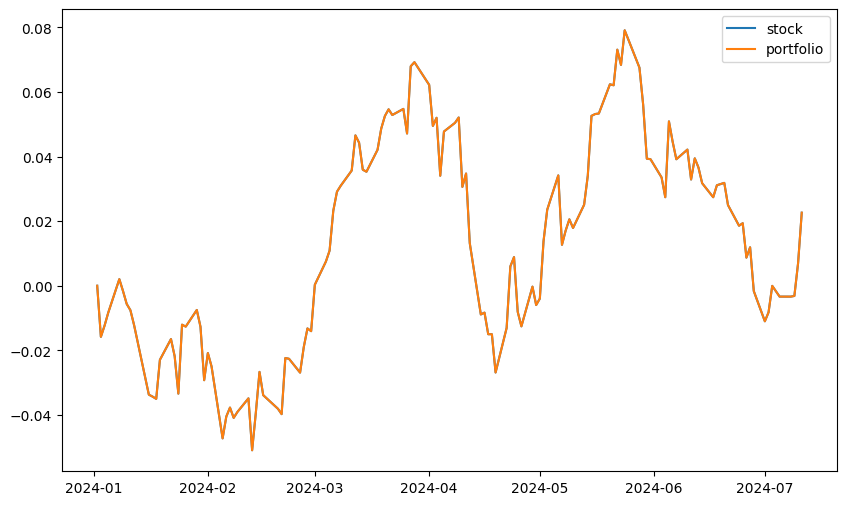

In [27]:
plt.figure(figsize=(10, 6))  
plt.plot(performance["date"].values,performance["stock_return"].values)
plt.plot(performance["date"].values,performance["return"].values)
plt.legend(["stock","portfolio"])

In [28]:
visualization = performance.merge(spy,on="date",how="left")
visualization = visualization.merge(market_yield[["date","rf"]],on="date",how="left")

In [29]:
visualization["return"] = (visualization["pv"] - visualization["pv"].iloc[0]) / visualization["pv"].iloc[0]
visualization["benchmark_return"] = (visualization["spy"] - visualization["spy"].iloc[0]) / visualization["spy"].iloc[0]
visualization["ir_return"] = (visualization["rf"] - visualization["rf"].iloc[0]) / visualization["rf"].iloc[0]

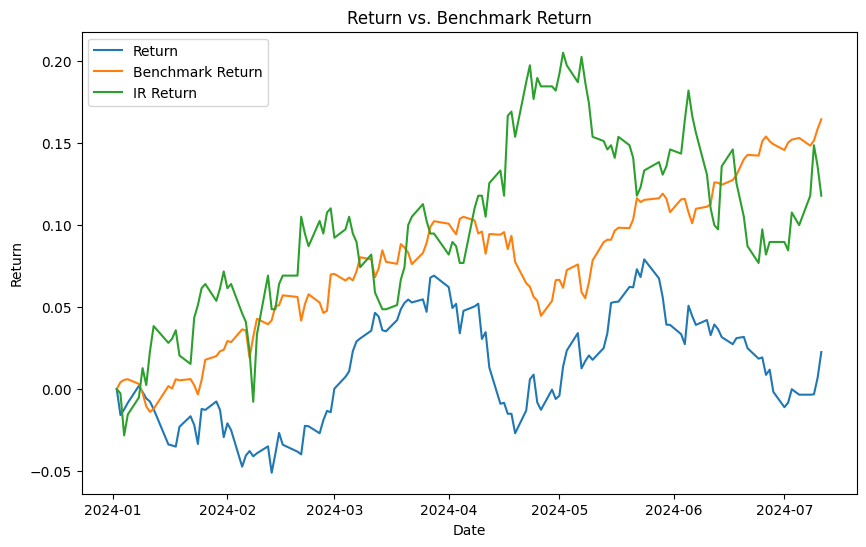

In [30]:
# Set the figure size
plt.figure(figsize=(10, 6))  # Adjust the width and height as needed

# Plot the data
plt.plot(visualization["date"].values, visualization["return"], label="Return")
plt.plot(visualization["date"].values, visualization["benchmark_return"], label="Benchmark Return")
plt.plot(visualization["date"].values, visualization["ir_return"], label="IR Return")

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Return")
plt.title("Return vs. Benchmark Return")
plt.legend()

# Show the plot
plt.show()


In [31]:
(visualization["return"].iloc[-1] - visualization["benchmark_return"].iloc[-1]) / visualization["return"].std()

-4.364515455686112

In [32]:
t = pd.DataFrame(trades).merge(sp500[["ticker","GICS Sub-Industry"]],on="ticker",how="left")
t["return"] = (t["adjclose"] - t["buy_price"]) / t["buy_price"]
t["hpr"] = t["sell_date"] - t["buy_date"]
t["hpr"] = [int(x.days) for x in t["hpr"]]

In [33]:
t.sort_values("return",ascending=False).head(50)

,ticker,adjclose,quantity,excess_return,buy_price,buy_date,sell_date,pv,GICS Sub-Industry,return,hpr
4,NRG,70.15,15.609756,0.081831,51.25,2024-01-02,2024-04-01,1095.024390,Independent Power Producers & Energy Traders,0.368780,90
80,LDOS,145.56,7.407407,0.042587,108.00,2024-01-02,2024-07-01,1078.222222,Diversified Support Services,0.347778,181
65,MPC,204.41,5.250722,0.050548,152.36,2024-01-02,2024-04-01,1073.300079,Oil & Gas Refining & Marketing,0.341625,90
22,ETN,312.03,3.348681,0.136980,238.90,2024-01-02,2024-04-01,1044.889075,Electrical Components & Equipment,0.306111,90
37,CMI,294.53,3.317025,0.128391,241.18,2024-01-02,2024-04-01,976.963264,Construction Machinery & Heavy Transportation ...,0.221204,90
70,VST,87.34,10.331360,0.042658,71.53,2024-04-01,2024-07-01,902.341001,Electric Utilities,0.221026,91
81,FIS,74.27,13.121207,0.042829,60.97,2024-01-02,2024-07-01,974.512055,Transaction & Payment Processing Services,0.218140,181
13,ALL,172.57,5.562895,0.070156,143.81,2024-01-02,2024-04-01,959.988874,Property & Casualty Insurance,0.199986,90
32,C,63.46,15.082956,0.149113,53.04,2024-01-02,2024-04-01,957.164404,Diversified Banks,0.196456,90
18,DAL,48.22,19.777503,0.208709,40.45,2024-01-02,2024-04-01,953.671199,Passenger Airlines,0.192089,90


In [34]:
t.groupby(["GICS Sub-Industry"]).agg({"return":"mean","hpr":"mean"}).reset_index().sort_values("return",ascending=False)

,GICS Sub-Industry,return,hpr
39,Independent Power Producers & Energy Traders,0.368780,90.0
20,Diversified Support Services,0.347778,181.0
57,Oil & Gas Refining & Marketing,0.341625,90.0
22,Electrical Components & Equipment,0.306111,90.0
14,Construction Machinery & Heavy Transportation ...,0.221204,90.0
...,...,...,...
73,Telecom Tower REITs,-0.117911,90.0
2,Agricultural Products & Services,-0.143073,90.0
46,Interactive Media & Services,-0.194177,181.0
7,Broadcasting,-0.246141,90.0


In [35]:
holdings = pd.DataFrame(sum([[x["stocks"][i] for x in states[-1]["positions"]] for i in range(number_of_stocks)],[]))
db.cloud_connect()
db.drop("trades")
db.drop("holdings")
db.drop("visualization")
db.store("visualization",visualization)
db.store("trades",t)
db.store("holdings",holdings.fillna(0))
db.disconnect() 